In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from vae import VAE
from tqdm import tqdm

import torchvision
import torchvision.datasets as datasets
from utils import train_model

torch.set_default_dtype(torch.float64)

/home/troch/miniconda3/envs/vae-venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/troch/miniconda3/envs/vae-venv/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/troch/miniconda3/envs/vae-venv/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
num_train = 60_000  # note cannot be greater than 60_000

mnist = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
mnist_iter = iter(torch.utils.data.DataLoader(mnist, shuffle=True))

training_images = []
for _ in tqdm(range(num_train)):
    img = next(mnist_iter)[0].squeeze(0).permute(1, 2, 0)
    training_images.append(img)


100%|██████████| 60000/60000 [00:06<00:00, 9267.17it/s] 


In [208]:
latent_dim = 32

vae_model = VAE(
    latent_dim = latent_dim,
    enc_architecture = 'cnn',
    # enc_mlp_hidden_dims = [64],
    enc_cnn_chans=[1, 32, 32, 32],
    dec_architecture = 'cnn',
    dec_cnn_chans=[32, 32, 32, 1],
    # dec_mlp_hidden_dims = [64],
    kernel_size=4,
    noise = 'homoscedastic',
    train_noise=False,
    noise_std=0.1,
    likelihood_activation=torch.nn.Sigmoid(),
)

print(vae_model)

VAE(
  (nonlinearity): ReLU()
  (posterior): DiagonalGaussian()
  (likelihood): GaussianLikelihood(
    (activation): Sigmoid()
  )
  (encoder): Encoder(
    (nonlinearity): ReLU()
    (posterior): DiagonalGaussian()
    (network): EncodingCNN(
      (net): Sequential(
        (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (5): AdaptiveAvgPool2d(output_size=(1, 1))
      )
    )
  )
  (decoder): Decoder(
    (nonlinearity): ReLU()
    (likelihood): GaussianLikelihood(
      (activation): Sigmoid()
    )
    (network): DecodingCNN(
      (net): Sequential(
        (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(3, 3))
        (1): ReLU()
        (2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(3, 3))
        (3): ReLU()
        (4): ConvTranspos

/home/troch/dev/vae/networks.py:174: UserWarning: Kernel size being made even for upsampling factor of 3
  Warning("Kernel size being made even for upsampling factor of 3")


In [209]:
tracker = train_model(
    vae_model,
    training_images,
    batch_size=5,
    lr=1e-3,
    max_epochs=5000,
    min_es_iters=500,
    early_stopping=False,
    )

epochs: 100%|██████████| 5000/5000 [00:49<00:00, 101.84it/s, elbo=213, ll=284, kl=71.3, noise=0.1, MAE=0.122]          


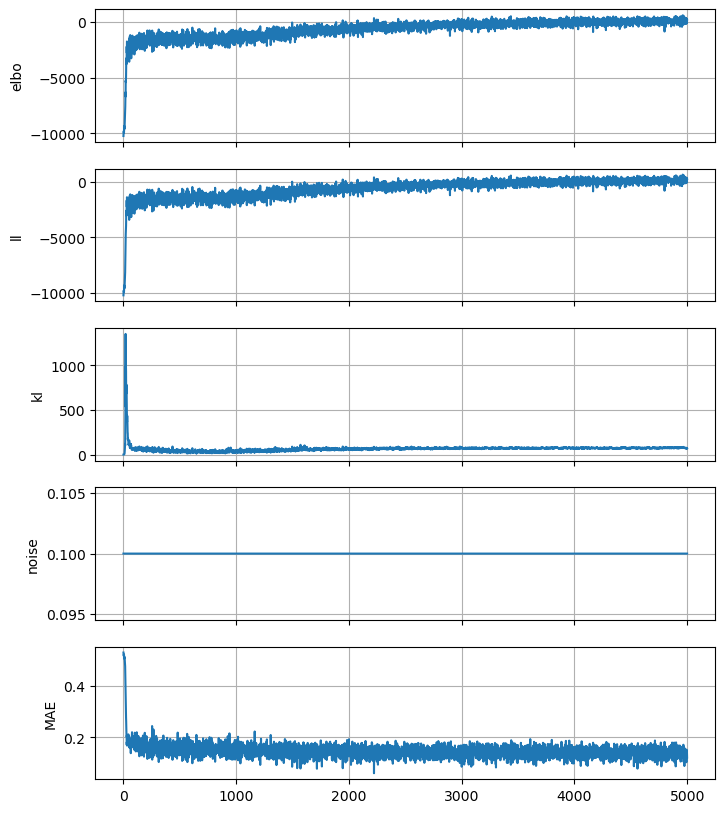

In [210]:
fig, axes = plt.subplots(
    len(tracker.keys()),
    1,
    figsize=(8, len(tracker.keys()) * 2),
    dpi=100,
    sharex=True,
)

for ax, (key, vals) in zip(axes, tracker.items()):
    ax.plot(vals)
    ax.set_ylabel(key)
    ax.grid()

plt.show()

In [211]:
torch.manual_seed(0)

num_test = 6

mnist_test = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
mnist_test_iter = iter(torch.utils.data.DataLoader(mnist_test, shuffle=False))

test_images = []
for _ in range(num_test):
    img = next(mnist_test_iter)[0].squeeze(0).permute(1, 2, 0)
    test_images.append(img.unsqueeze(0))

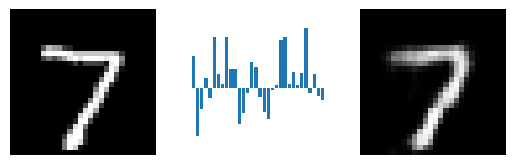

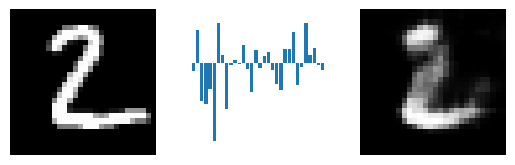

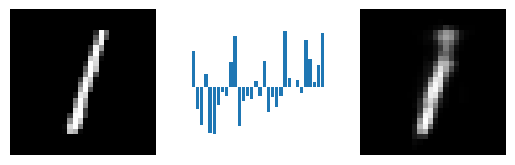

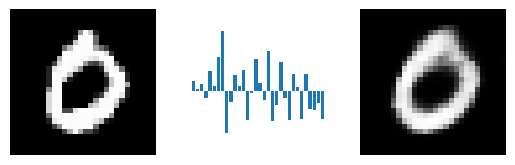

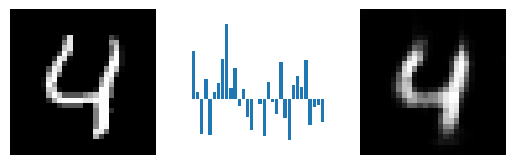

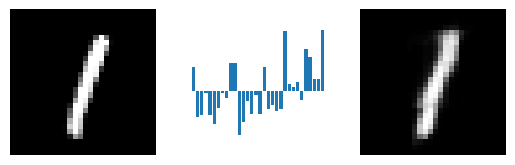

In [212]:
for image in test_images:
    with torch.no_grad():
        q, z, p = vae_model(image)
    reconstruction = p.loc.squeeze(0).squeeze(0).view(28, 28, 1)
    uncertainty = p.scale.squeeze(0).squeeze(0).view(28, 28, 1)
    
    hetero = vae_model.likelihood.noise != 'homoscedastic'
    ld = vae_model.latent_dim
    vmin = None
    vmax = None
    noise_cmap = "viridis"
    if vae_model.likelihood.noise.startswith('imagewise'):
        vmin = 0
        vmax = 0.25
        noise_cmap = "gray"  # darker = more confident
    
    fig, axes = plt.subplots(1, 3 + int(hetero))
    axes[0].imshow(image.squeeze(0).numpy(), cmap="gray")
    axes[0].axis(False)
    axes[1].bar([i for i in range(ld)], (0.15*ld*z.squeeze()).tolist())
    axes[1].axis(False)
    axes[1].set_aspect('equal')
    axes[2].imshow(reconstruction.numpy(), cmap="gray")
    axes[2].axis(False)
    if hetero:
        axes[3].imshow(uncertainty.numpy(), cmap=noise_cmap, vmin=vmin, vmax=vmax)
        axes[3].axis(False)
    
    plt.show()
    

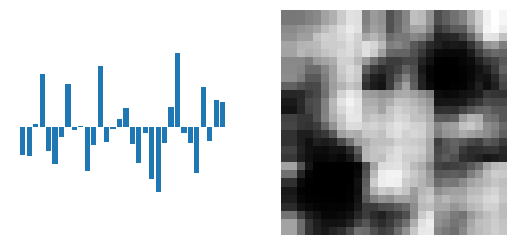

In [221]:
z_test = torch.randn(latent_dim)
with torch.no_grad():
    p = vae_model.generate(z_test)
reconstruction = p.loc.squeeze(0).squeeze(0).view(28, 28, 1)
uncertainty = p.scale.squeeze(0).squeeze(0).view(28, 28, 1)

hetero = vae_model.likelihood.noise != 'homoscedastic'
ld = vae_model.latent_dim
vmin = None
vmax = None
noise_cmap = "viridis"
if vae_model.likelihood.noise.startswith('imagewise'):
    vmin = 0
    vmax = 0.25
    noise_cmap = "gray"  # darker = more confident

fig, axes = plt.subplots(1, 2 + int(hetero))
axes[0].bar([i for i in range(latent_dim)], (0.15*ld*z_test.squeeze()).tolist())
axes[0].axis(False)
axes[0].set_aspect('equal')
axes[1].imshow(reconstruction.numpy(), cmap="gray")
axes[1].axis(False)
if hetero:
    axes[2].imshow(uncertainty.numpy(), cmap=noise_cmap, vmin=vmin, vmax=vmax)
    axes[2].axis(False)

plt.show()